# Speech Emotion Recognition (SER)

# Kelompok 5
1) Putu Yuki Parmawati (2208561066)

2) Ni Luh Gede Cahaya Putri Mahadewi (2208561110)

3) Made Pranajaya Dibyacita (2208561122)

4) Amsal Hamonangan Butarbutar (2208561134)

# Import Library

In [34]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, KFold
import seaborn as sns

import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

import joblib
import os
import glob 
import pandas as pd
import IPython.display as ipd
import plotly.express as px
import scipy.io.wavfile
import sys
import warnings
import logging
from absl import logging as absl_logging

if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings('ignore', category=UserWarning)
logging.getLogger('absl').setLevel(logging.ERROR)
sys.stderr = open(os.devnull, 'w')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')
print("Python Version: {}".format(sys.version))
print("Keras Version: {}".format(keras.__version__))
print("Tensorflow Version: {}".format(tf.__version__))

Python Version: 3.10.13 | packaged by conda-forge | (main, Dec 23 2023, 15:36:39) [GCC 12.3.0]
Keras Version: 3.3.3
Tensorflow Version: 2.15.0


### Inisiasi Dataset

In [3]:
RAV = '/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/'
dir_list = os.listdir(RAV)
print(dir_list)

['Actor_02', 'Actor_17', 'Actor_05', 'Actor_16', 'Actor_21', 'Actor_01', 'Actor_11', 'Actor_20', 'Actor_08', 'Actor_15', 'Actor_06', 'Actor_12', 'Actor_23', 'Actor_24', 'Actor_22', 'Actor_04', 'Actor_19', 'Actor_10', 'Actor_09', 'Actor_14', 'Actor_03', 'Actor_13', 'Actor_18', 'Actor_07']


### Memproses data dari dataset RAVDESS dan membuat DataFrame.

In [4]:
emotion = []
gender = []
path = []
feature = []
for i in dir_list:
    fname = os.listdir(RAV + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAV + i + '/' + f)

RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender),RAV_df],axis=1)
RAV_df.columns = ['gender','emotion']
RAV_df['labels'] =RAV_df.gender + '_' + RAV_df.emotion
RAV_df['source'] = 'RAVDESS'
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAV_df = RAV_df.drop(['gender'], axis=1)
RAV_df.labels.value_counts()

labels
female_surprise    96
female_disgust     96
female_fear        96
female_sad         96
female_happy       96
female_calm        96
female_angry       96
male_calm          96
male_surprise      96
male_angry         96
male_happy         96
male_disgust       96
male_fear          96
male_sad           96
female_neutral     48
male_neutral       48
Name: count, dtype: int64

In [5]:
display(RAV_df.head())

emotion           labels   source  \
0  surprise  female_surprise  RAVDESS   
1   neutral   female_neutral  RAVDESS   
2   disgust   female_disgust  RAVDESS   
3   disgust   female_disgust  RAVDESS   
4   neutral   female_neutral  RAVDESS   

                                                path  
0  /kaggle/input/ravdess-emotional-speech-audio/a...  
1  /kaggle/input/ravdess-emotional-speech-audio/a...  
2  /kaggle/input/ravdess-emotional-speech-audio/a...  
3  /kaggle/input/ravdess-emotional-speech-audio/a...  
4  /kaggle/input/ravdess-emotional-speech-audio/a...

In [6]:
display(RAV_df.describe())

emotion           labels   source  \
count       1440             1440     1440   
unique         8               16        1   
top     surprise  female_surprise  RAVDESS   
freq         192               96     1440   

                                                     path  
count                                                1440  
unique                                               1440  
top     /kaggle/input/ravdess-emotional-speech-audio/a...  
freq                                                    1

### Visualisasi Data

In [7]:
px_fig = px.histogram(RAV_df, x='emotion', color='emotion', marginal='box',  
                      title='Jumlah Emosi')
px_fig.update_layout(bargap=0.2)
px_fig.show()

px_fig = px.histogram(RAV_df, x='labels', color='emotion', marginal='box',  
                      title='Jumlah Label')
px_fig.update_layout(bargap=0.2)
px_fig.show()

Mernampilkan emosi

In [8]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot untuk audio dengan emosi {}'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

In [9]:
def create_spectrogram(data, sr, e):
    # Fungsi stft mengubah data menjadi transformasi Fourier jangka pendek
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram untuk audio dengan emosi {}'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

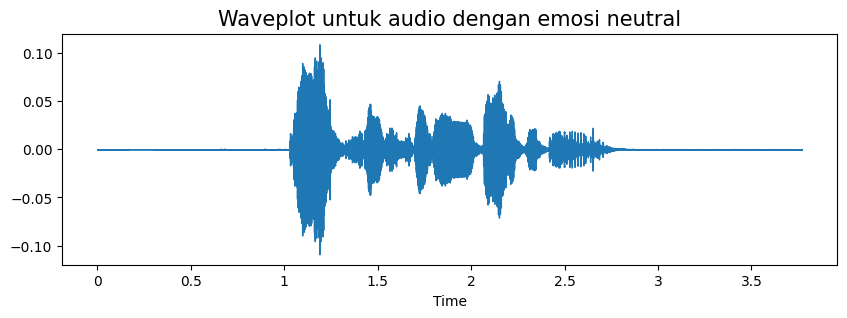

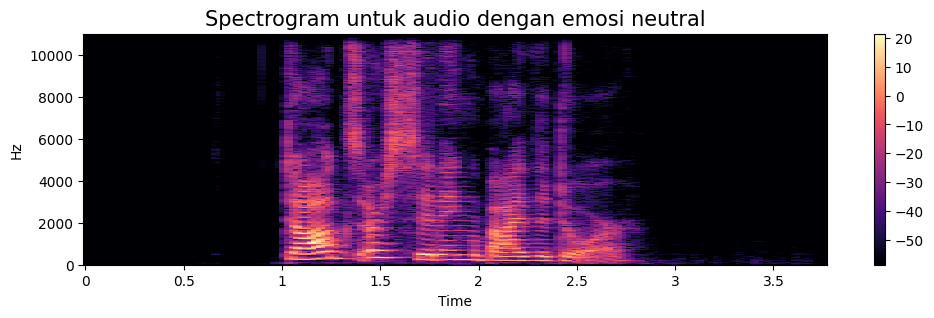

In [10]:
emotion='neutral'
path = np.array(RAV_df.path[RAV_df.emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
ipd.Audio(path)

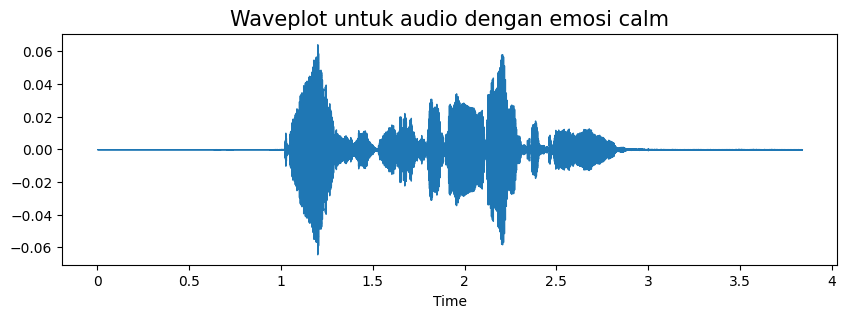

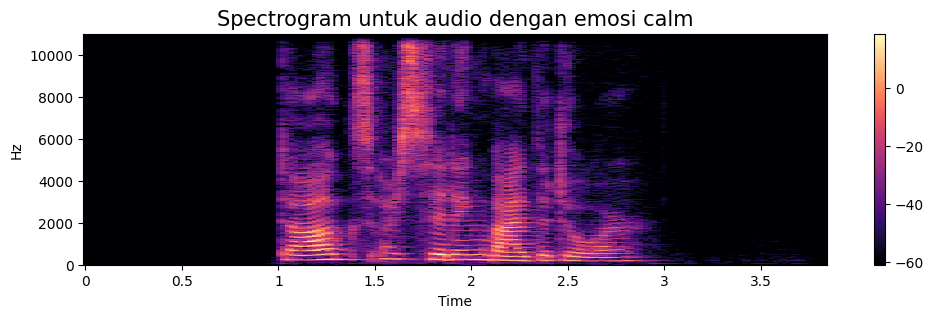

In [11]:
emotion='calm'
path = np.array(RAV_df.path[RAV_df.emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
ipd.Audio(path)

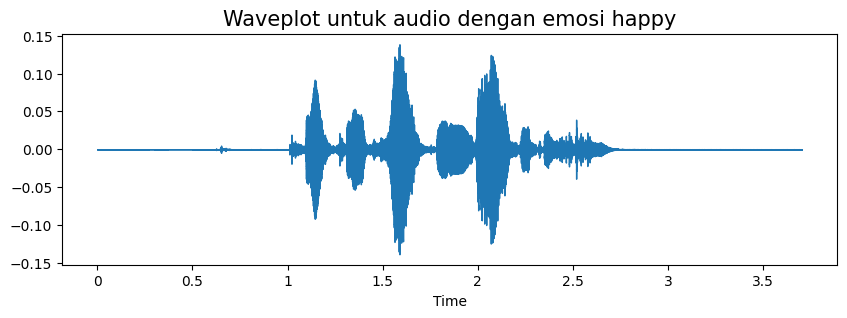

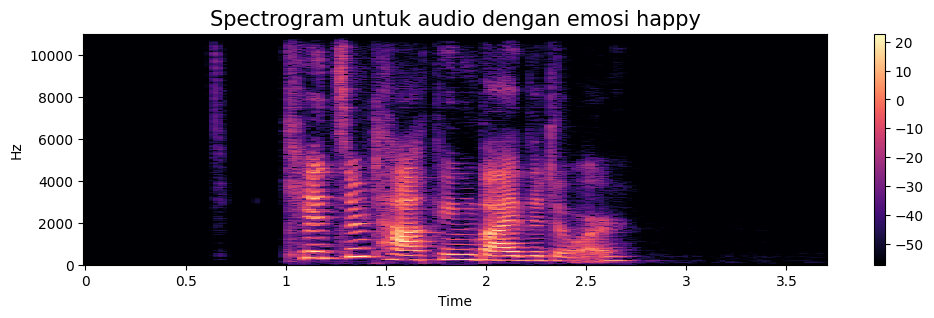

In [12]:
emotion='happy'
path = np.array(RAV_df.path[RAV_df.emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
ipd.Audio(path)

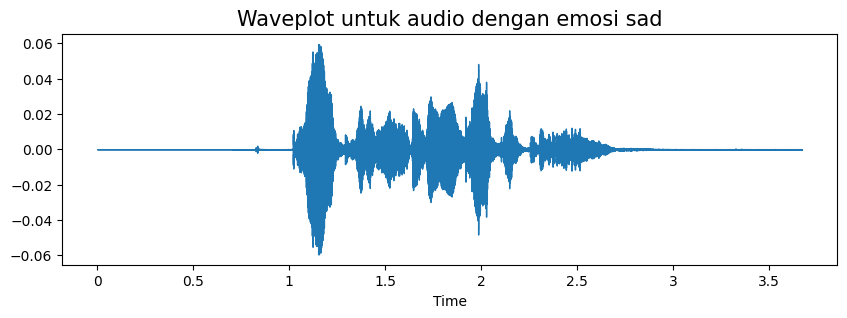

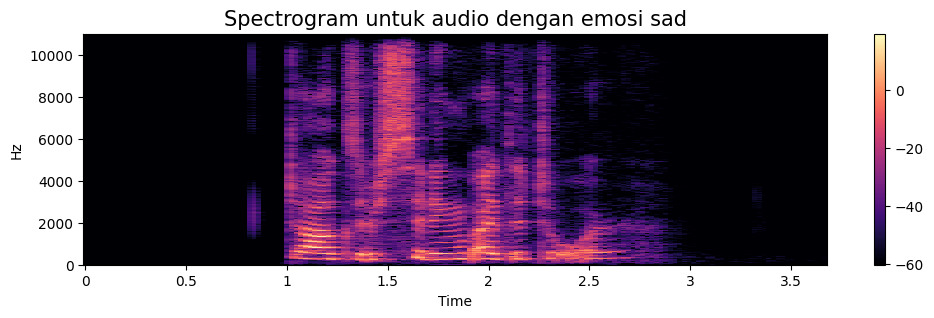

In [13]:
emotion='sad'
path = np.array(RAV_df.path[RAV_df.emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
ipd.Audio(path)

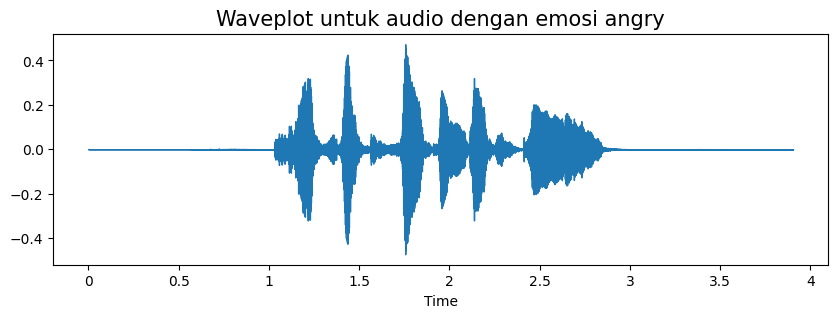

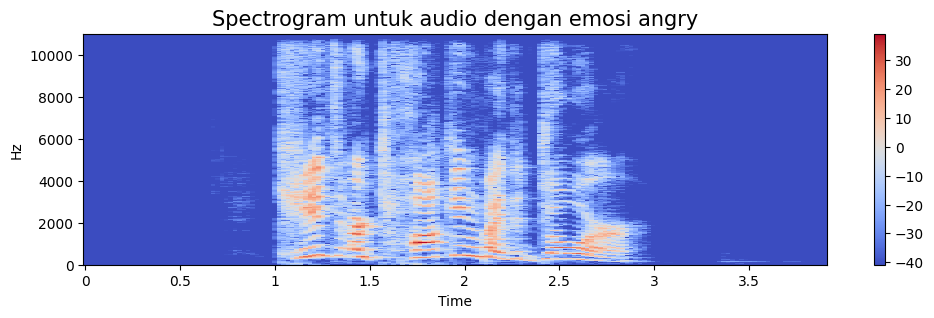

In [14]:
emotion='angry'
path = np.array(RAV_df.path[RAV_df.emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
ipd.Audio(path)

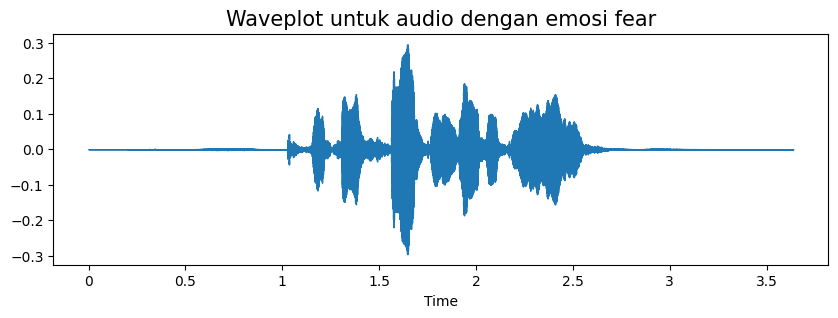

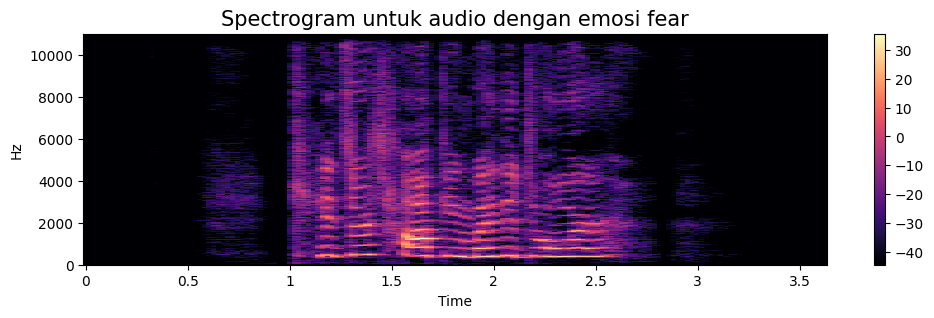

In [15]:
emotion='fear'
path = np.array(RAV_df.path[RAV_df.emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
ipd.Audio(path)

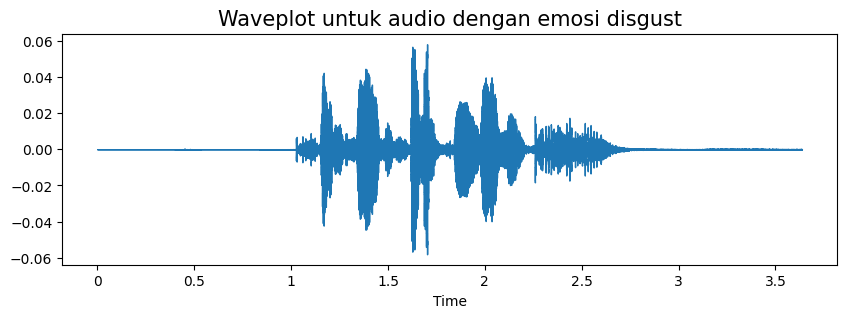

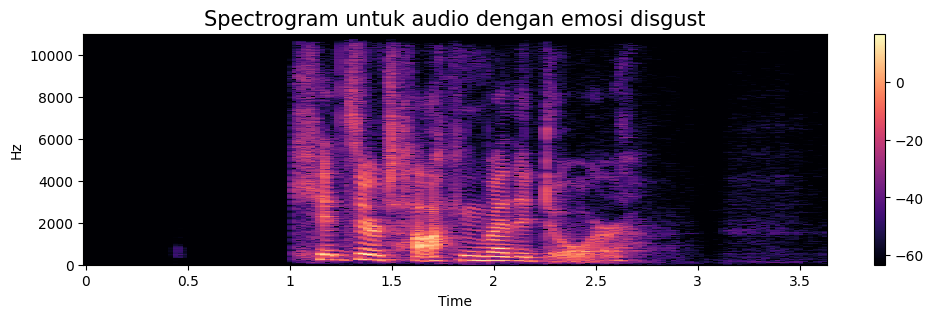

In [16]:
emotion='disgust'
path = np.array(RAV_df.path[RAV_df.emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
ipd.Audio(path)

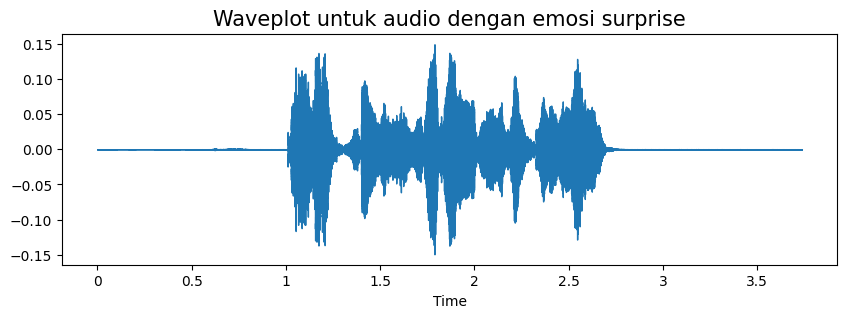

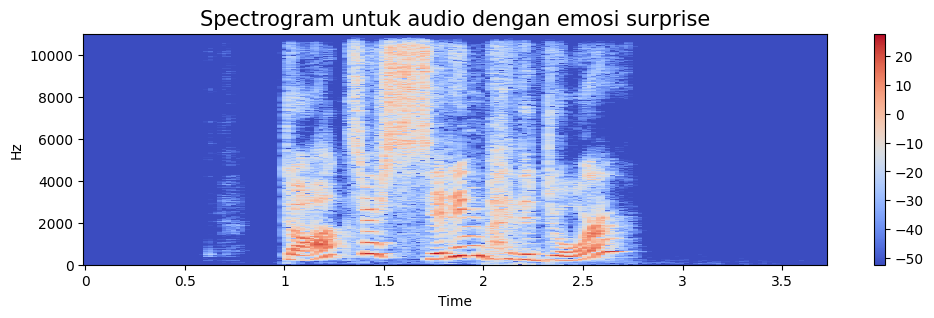

In [17]:
emotion='surprise'
path = np.array(RAV_df.path[RAV_df.emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
ipd.Audio(path)

# Preprocessing dengan augmentasi data
Menambahkan noise, dan pitch

In [18]:
class DataAugmentation:
    @staticmethod
    def noise(data, noise_factor=0.005):
        # Menambahkan noise acak ke data audio
        noise_amp = noise_factor * np.random.uniform() * np.amax(data)
        return data + noise_amp * np.random.normal(size=data.shape[0])
    
    @staticmethod
    def pitch(data, sr, n_steps=4):
        # Mengubah pitch data audio
        return librosa.effects.pitch_shift(y=data, sr=sr, n_steps=n_steps)

# Mengambil contoh data audio dan menerapkan teknik augmentasi
path = np.array(RAV_df.path)[1]
data, sample_rate = librosa.load(path)

# Contoh penggunaan
augmented_data_noise = DataAugmentation.noise(data)
augmented_data_pitch = DataAugmentation.pitch(data, sample_rate)

### Audio Original

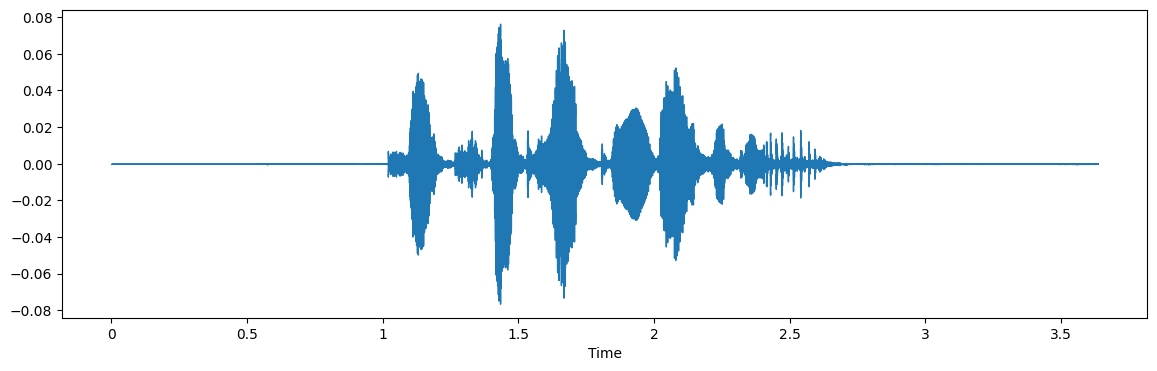

In [19]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
ipd.Audio(path)

### Noise

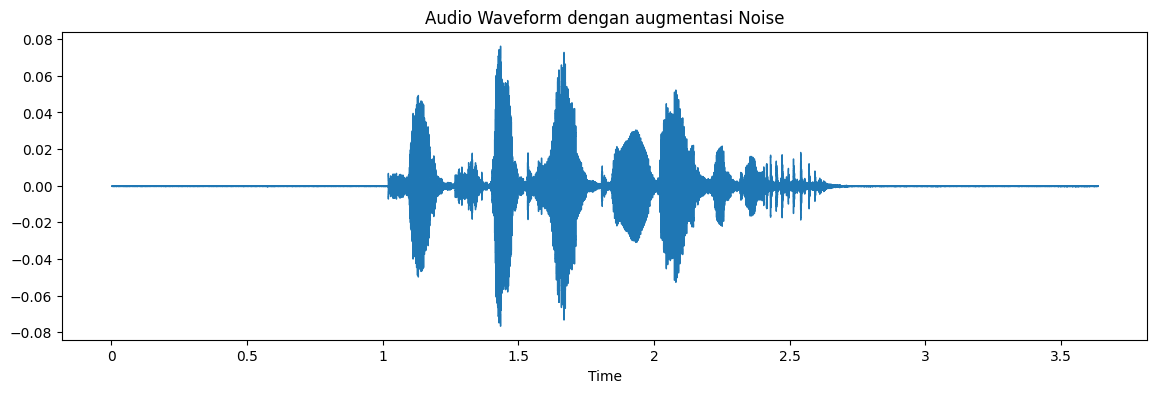

In [20]:
# Menggunakan metode augmentasi noise dari kelas DataAugmentation
x = DataAugmentation.noise(data)

# Menampilkan grafik waveform
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=x, sr=sample_rate)
plt.title('Audio Waveform dengan augmentasi Noise')
plt.show()

# Memutar audio
ipd.Audio(x, rate=sample_rate)

### Pitch

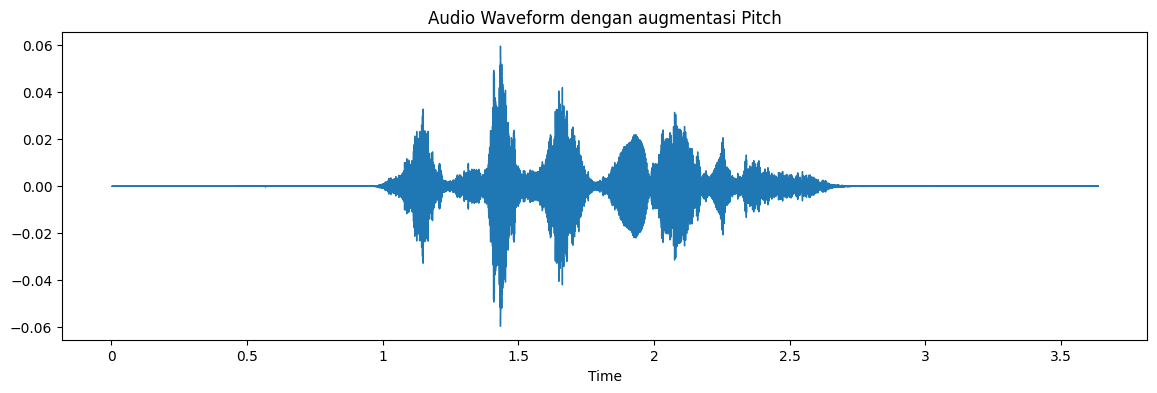

In [21]:
# Menggunakan metode augmentasi noise dari kelas DataAugmentation
x = DataAugmentation.pitch(data, sample_rate)

# Menampilkan grafik waveform
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=x, sr=sample_rate)
plt.title('Audio Waveform dengan augmentasi Pitch')
plt.show()

# Memutar audio
ipd.Audio(x, rate=sample_rate)

# Ekstraksi Fitur & Persiapan Data

Menggunakan 6 jenis ekstraksi fitur:

- Zero Crossing Rate (ZCR): Mengukur seberapa sering sinyal audio melewati garis nol, berguna untuk membedakan jenis suara seperti bicara dan musik.

- Chroma STFT: Menangkap konten harmonik dari sinyal audio, berguna untuk mengidentifikasi nada dan akor dalam musik.

- **Mel-frequency Cepstral Coefficients (MFCC)**: Merepresentasikan spektrum daya jangka pendek dari sinyal audio, sangat umum digunakan dalam pengenalan suara dan musik.

- Root Mean Square Energy (RMSE): Mengukur energi dari sinyal audio, menunjukkan tingkat kekerasan suara atau intensitas.

- Spectral Contrast: Mengukur perbedaan antara puncak dan lembah dalam spektrum, berguna untuk mengidentifikasi tekstur timbre dan karakteristik harmonik.

- Mel Spectrogram: Menyediakan representasi frekuensi yang terperinci dari sinyal audio, sangat berguna untuk mengidentifikasi tekstur timbre.

In [22]:
class FeatureExtractor:
    def __init__(self, frame_length=2048, hop_length=512):
        # Inisialisasi parameter panjang frame dan panjang hop
        self.frame_length = frame_length
        self.hop_length = hop_length

    def zcr(self, data):
        # Menghitung Zero Crossing Rate (ZCR) dari data audio
        return librosa.feature.zero_crossing_rate(data, frame_length=self.frame_length, hop_length=self.hop_length).flatten()

    def rmse(self, data):
        # Menghitung Root Mean Square Energy (RMSE) dari data audio
        return librosa.feature.rms(y=data, frame_length=self.frame_length, hop_length=self.hop_length).flatten()

    def mfcc(self, data, sr, n_mfcc=13, flatten=True):
        # Menghitung Mel-frequency Cepstral Coefficients (MFCC) dari data audio
        mfcc_features = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=n_mfcc, hop_length=self.hop_length)
        return mfcc_features.T.flatten() if flatten else mfcc_features.T

    def chroma(self, data, sr):
        # Menghitung Chroma dari data audio
        chroma_features = librosa.feature.chroma_stft(y=data, sr=sr, hop_length=self.hop_length)
        return chroma_features.T.flatten()

    def spectral_contrast(self, data, sr):
        # Menghitung Spectral Contrast dari data audio
        contrast_features = librosa.feature.spectral_contrast(y=data, sr=sr, hop_length=self.hop_length)
        return contrast_features.T.flatten()

    def mel_spectrogram(self, data, sr):
        # Menghitung Mel Spectrogram dari data audio dan mengubahnya ke dB
        mel_features = librosa.feature.melspectrogram(y=data, sr=sr, hop_length=self.hop_length)
        return librosa.power_to_db(mel_features).flatten()

    def extract_features(self, data, sr):
        # Mengekstraksi semua fitur dari data audio
        zcr_features = self.zcr(data)
        rmse_features = self.rmse(data)
        mfcc_features = self.mfcc(data, sr)
        chroma_features = self.chroma(data, sr)
        spectral_contrast_features = self.spectral_contrast(data, sr)
        mel_spectrogram_features = self.mel_spectrogram(data, sr)
        return np.concatenate([zcr_features,
                                rmse_features,
                                mfcc_features,
                                chroma_features,
                                spectral_contrast_features,
                                mel_spectrogram_features])

### Proses Ekstraksi Fitur Dengan Augmentasi
`get_features(path, duration=2.5, offset=0.6)`: Memuat file audio dan mengekstraksi fitur menggunakan beberapa teknik augmentasi:
- Original Audio: Mengekstraksi fitur dari audio asli.
- Noised Audio: Menambahkan noise ke audio dan mengekstraksi fitur.
- Pitched Audio: Mengubah pitch audio dan mengekstraksi fitur.
- Pitched Noised Audio: Menambahkan noise dan mengubah pitch, kemudian mengekstraksi fitur.

In [23]:
from joblib import Parallel, delayed

class AudioProcessor:
    def __init__(self, frame_length=2048, hop_length=512):
        # Inisialisasi ekstraktor fitur dan pengolah augmentasi data
        self.feature_extractor = FeatureExtractor(frame_length, hop_length)
        self.augmenter = DataAugmentation()

    def get_features(self, path, duration=2.5, offset=0.6):
        # Memuat file audio dan mengekstraksi fitur
        data, sr = librosa.load(path, duration=duration, offset=offset)
        features = [self.feature_extractor.extract_features(data, sr)]

        # Menambahkan noise ke audio dan mengekstraksi fitur
        noised_audio = self.augmenter.noise(data)
        features.append(self.feature_extractor.extract_features(noised_audio, sr))

        # Mengubah pitch audio dan mengekstraksi fitur
        pitched_audio = self.augmenter.pitch(data, sr)
        features.append(self.feature_extractor.extract_features(pitched_audio, sr))

        # Menambahkan noise dan mengubah pitch, kemudian mengekstraksi fitur
        pitched_noised_audio = self.augmenter.noise(pitched_audio)
        features.append(self.feature_extractor.extract_features(pitched_noised_audio, sr))

        return np.array(features)

    def process_feature(self, path, emotion):
        # Memproses fitur dan membuat label untuk satu file audio
        features = self.get_features(path)
        X = features.tolist()
        Y = [emotion] * len(features)
        return X, Y

    def process_dataset(self, df, n_jobs=-1):
        # Memproses fitur untuk semua file audio dalam dataset
        paths = df['path'].values
        emotions = df['emotion'].values

        # Menggunakan pemrosesan paralel untuk mempercepat ekstraksi fitur
        results = Parallel(n_jobs=n_jobs)(delayed(self.process_feature)(path, emotion) for path, emotion in zip(paths, emotions))

        X, Y = [], []
        for result in results:
            X.extend(result[0])
            Y.extend(result[1])

        # Menyamakan panjang urutan dengan padding atau pemangkasan
        max_len = max(len(x) for x in X)
        X = np.array([np.pad(x, (0, max_len - len(x)), 'constant') if len(x) < max_len else x[:max_len] for x in X])

        return X, np.array(Y)

# Contoh penggunaan
processor = AudioProcessor()

X, Y = processor.process_dataset(RAV_df)
print(X.shape, Y.shape)

(5760, 17496) (5760,)


In [24]:
# Membuat DataFrame dari fitur dan label
Features = pd.DataFrame(X)
Features['labels'] = Y

# Menyimpan DataFrame ke file CSV
Features.to_csv('features.csv', index=False)

In [25]:
# Menampilkan beberapa baris pertama dan deskripsi statistik DataFrame
display(Features.head())
display(Features.describe())

0         1         2         3         4         5         6  \
0  0.343750  0.479492  0.573730  0.458008  0.375488  0.301758  0.269043   
1  0.238770  0.367188  0.479004  0.467285  0.447266  0.418945  0.385254   
2  0.314941  0.441406  0.547363  0.474609  0.397949  0.353027  0.330566   
3  0.248047  0.376953  0.498535  0.491699  0.484863  0.461426  0.448730   
4  0.437500  0.659668  0.862305  0.878906  0.865234  0.847168  0.845703   

          7         8         9  ...      17487      17488      17489  \
0  0.255371  0.251465  0.251953  ... -67.986168 -67.986168 -67.986168   
1  0.362793  0.349121  0.335938  ... -51.277880 -51.286126 -49.998787   
2  0.321777  0.312988  0.302246  ... -69.387115 -69.387115 -69.387115   
3  0.437988  0.433105  0.443359  ... -47.802728 -48.090953 -47.149884   
4  0.827637  0.835938  0.667969  ... -73.314407 -73.314407 -73.314407   

       17490      17491      17492      17493      17494      17495    labels  
0 -67.986168 -67.986168 -67.986168 -67.986168 -67.986168 -67.986168  surprise  
1 -49.315214 -49.958471 -51.729967 -51.486034 -50.359494 -50.164439  surprise  
2 -69.387115 -69.387115 -69.387115 -69.387115 -69.387115 -69.387115  surprise  
3 -46.976819 -45.105181 -45.350256 -47.443210 -47.461019 -49.077597  surprise  
4 -73.314407 -73.314407 -73.314407 -73.314407 -73.314407 -73.314407   neutral  

[5 rows x 17497 columns]

0            1            2            3            4      \
count  5760.000000  5760.000000  5760.000000  5760.000000  5760.000000   
mean      0.189542     0.283204     0.376204     0.372931     0.372999   
std       0.091968     0.133535     0.173407     0.173072     0.171171   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.129883     0.196289     0.260742     0.256348     0.258179   
50%       0.218018     0.322754     0.425781     0.417969     0.415527   
75%       0.249023     0.373047     0.496582     0.495117     0.494629   
max       0.461914     0.687500     0.916504     0.922852     0.920410   

             5            6            7            8            9      ...  \
count  5760.000000  5760.000000  5760.000000  5760.000000  5760.000000  ...   
mean      0.373854     0.375253     0.377526     0.380304     0.382795  ...   
std       0.170235     0.169186     0.166816     0.165491     0.165366  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       0.256348     0.260742     0.263184     0.266479     0.270996  ...   
50%       0.417236     0.420166     0.418213     0.420898     0.423340  ...   
75%       0.494751     0.495117     0.494141     0.493652     0.494629  ...   
max       0.923828     0.921387     0.930176     0.931641     0.897461  ...   

             17486        17487        17488        17489        17490  \
count  5760.000000  5760.000000  5760.000000  5760.000000  5760.000000   
mean    -62.378342   -62.388419   -62.418867   -62.456112   -62.487786   
std      14.325745    14.346757    14.349714    14.336451    14.326166   
min     -99.173401   -99.173401   -99.173401   -99.173401   -99.173401   
25%     -72.406976   -72.515450   -72.524687   -72.513716   -72.530167   
50%     -63.755680   -63.724195   -63.805169   -63.832372   -63.887913   
75%     -53.625974   -53.694796   -53.765611   -53.715618   -53.948157   
max       0.000000     0.000000     0.000000     0.000000     0.000000   

             17491        17492        17493        17494        17495  
count  5760.000000  5760.000000  5760.000000  5760.000000  5760.000000  
mean    -62.528644   -62.570139   -62.637170   -62.679691   -62.827150  
std      14.314166    14.307554    14.270912    14.240579    14.162638  
min     -99.173401   -99.173401   -99.173401   -99.173401   -99.173401  
25%     -72.559731   -72.517828   -72.567602   -72.617289   -72.674090  
50%     -63.888147   -63.929158   -64.057331   -64.150009   -64.142007  
75%     -54.023211   -54.069007   -54.292798   -54.334267   -54.422033  
max       0.000000     0.000000     0.000000     0.000000     0.000000  

[8 rows x 17496 columns]

###  Persiapan data untuk pelatihan dengan CNN, termasuk standardisasi fitur, pengkodean label, dan pembagian data menjadi set pelatihan dan pengujian. 

In [26]:
def prepare_data_for_cnn(X, Y):
    # Menstandardisasi fitur
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    joblib.dump(scaler, 'scaler.pkl')

    # Mengenkode label
    encoder = LabelEncoder()
    Y = encoder.fit_transform(Y)
    joblib.dump(encoder, 'label_encoder.pkl')

    num_classes = len(np.unique(Y))
    Y = to_categorical(Y, num_classes=num_classes)

    # Membagi data menjadi set pelatihan dan pengujian
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    # Mengubah bentuk data untuk CNN (menambahkan dimensi ekstra untuk saluran)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1, 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1, 1))

    return X_train, X_test, Y_train, Y_test, num_classes

# Memanggil fungsi prepare_data_for_cnn
X_train, X_test, Y_train, Y_test, num_classes = prepare_data_for_cnn(X, Y)
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(4608, 17496, 1, 1) (4608, 8) (1152, 17496, 1, 1) (1152, 8)


# Training & Modelling
CNN

In [27]:
# Membbangun Model CNN
def build_cnn_model(input_shape, num_classes):
    # Membuat model Sequential
    model = Sequential()
    # Menambahkan layer Conv2D pertama dengan 16 filter
    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=input_shape, padding='same'))
    # Menambahkan layer MaxPooling2D
    model.add(MaxPooling2D((2, 1)))
    # Menambahkan layer Conv2D kedua dengan 32 filter
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    # Menambahkan layer MaxPooling2D
    model.add(MaxPooling2D((2, 1)))
    # Meratakan layer untuk mempersiapkan input ke Dense layer
    model.add(Flatten())
    # Menambahkan Dense layer dengan 64 unit
    model.add(Dense(64, activation='relu'))
    # Menambahkan Dense layer terakhir untuk output dengan softmax
    model.add(Dense(num_classes, activation='softmax'))
    
    # Mengompilasi model dengan optimizer Adam dan loss categorical crossentropy
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Pengunaan
cnn_model = build_cnn_model(X_train.shape[1:], num_classes)

# Menampilkan ringkasan model
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 17496, 1, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 8748, 1, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8748, 1, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4374, 1, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 139968)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     8,958,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,963,336 (34.19 MB)

 Trainable params: 8,963,336 (34.19 MB)

 Non-trainable params: 0 (0.00 B)

### K-Fold Cross Validation & Hyperparameter Tuning

In [28]:
# Asumsikan X dan Y adalah matriks fitur dan label Anda
# Contoh langkah preprocessing
# X, Y = processor.process_dataset(RAV_df)

# Mempersiapkan data
X_train, X_test, Y_train, Y_test, num_classes = prepare_data_for_cnn(X, Y)
input_shape = X_train.shape[1:]

### k = 5

In [29]:
# Mendefinisikan K-Fold Cross-Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

### Hyperparameter yang akan dipakai

In [30]:
# Hyperparameter tuning
best_accuracy = 0
best_params = {}

# Daftar hyperparameter untuk dicoba
epochs_list = [10, 20]
batch_size_list = [16, 32]

### Mencari best paramter dengan k-fold dan hyperparameter yang sudah dinisiasi diatas

In [35]:
for epochs in epochs_list:
    for batch_size in batch_size_list:
        fold_accuracy = [] # Menyimpan akurasi setiap lipatan

        for train_idx, val_idx in kfold.split(X_train):
            # Membagi data menjadi set pelatihan dan validasi
            X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
            Y_train_fold, Y_val_fold = Y_train[train_idx], Y_train[val_idx]

            # Membangun dan melatih model dengan hyperparameter yang berbeda
            model = build_cnn_model(input_shape=input_shape, num_classes=num_classes)
            model.fit(X_train_fold, Y_train_fold, epochs=epochs, batch_size=batch_size, validation_data=(X_val_fold, Y_val_fold), verbose=0)

            # Evaluasi model pada data validasi
            scores = model.evaluate(X_val_fold, Y_val_fold, verbose=0)
            fold_accuracy.append(scores[1]) # Menyimpan akurasi validasi

        # Menghitung rata-rata akurasi dari semua lipatan
        avg_accuracy = np.mean(fold_accuracy)
        if avg_accuracy > best_accuracy:
            best_accuracy = avg_accuracy # Memperbarui akurasi terbaik
            best_params = {'epochs': epochs, 'batch_size': batch_size} # Menyimpan parameter terbaik

In [36]:
print(f"Best accuracy: {best_accuracy}")
print(f"Best parameters: {best_params}")

Best accuracy: 0.8975762009620667
Best parameters: {'epochs': 20, 'batch_size': 32}


### Melatih model CNN dengan best parameter yang ditemukan

In [37]:
# Melatih model akhir dengan hyperparameter terbaik pada seluruh data pelatihan
final_model = build_cnn_model(input_shape=input_shape, num_classes=num_classes)
history = final_model.fit(X_train, Y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], validation_data=(X_test, Y_test))

Epoch 1/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.3613 - loss: 1.8571 - val_accuracy: 0.6615 - val_loss: 0.9599
Epoch 2/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7968 - loss: 0.6395 - val_accuracy: 0.8576 - val_loss: 0.4538
Epoch 3/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9686 - loss: 0.1357 - val_accuracy: 0.8542 - val_loss: 0.5403
Epoch 4/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9875 - loss: 0.0536 - val_accuracy: 0.9375 - val_loss: 0.2695
Epoch 5/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9976 - loss: 0.0379 - val_accuracy: 0.9262 - val_loss: 0.2512
Epoch 6/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9937 - loss: 0.0317 - val_accuracy: 0.9410 - val_loss: 0.2067
Epoch 7/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9997 - loss: 0.0036 - val_accuracy: 0.9453 - val_loss: 0.1905
Epoch 8/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9996 - loss: 0.0026 - val_accu

In [47]:
# Menampilkan ringkasan model
final_model.summary()

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_62 (Conv2D)              │ (None, 17496, 1, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_62 (MaxPooling2D) │ (None, 8748, 1, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 8748, 1, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_63 (MaxPooling2D) │ (None, 4374, 1, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_31 (Flatten)            │ (None, 139968)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 64)             │     8,958,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,890,010 (102.58 MB)

 Trainable params: 8,963,336 (34.19 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,926,674 (68.38 MB)

# Evaluasi
Cari akruasi pada dataset test dan plot training & testing akurasi

Akurasi model pada dataset test: 94.61805820465088 % 



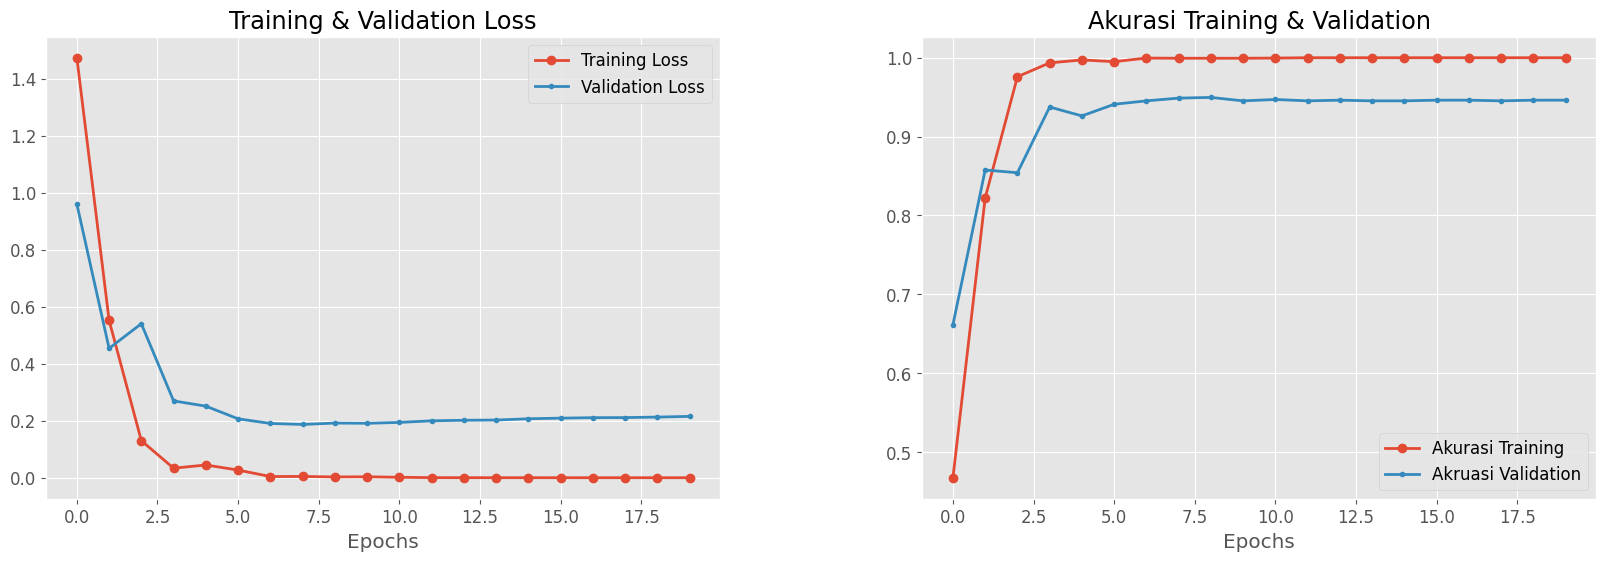

In [48]:
# Menampilkan akurasi model pada data pengujian
print("Akurasi model pada dataset test:", final_model.evaluate(X_test, Y_test, verbose=0)[1] * 100, "% \n")

# Menghitung jumlah epoch dari history
epochs = range(len(history.history['loss']))

# Mengekstrak metrik pelatihan dan pengujian dari history
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Menggunakan gaya yang valid
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 12})

# Membuat subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

# Memplot loss pelatihan dan validasi
ax[0].plot(epochs, train_loss, label='Training Loss', marker='o', linewidth=2)
ax[0].plot(epochs, val_loss, label='Validation Loss', marker='.', linewidth=2)
ax[0].set_title('Training & Validation Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

# Memplot akurasi pelatihan dan validasi
ax[1].plot(epochs, train_acc, label='Akurasi Training', marker='o', linewidth=2)
ax[1].plot(epochs, val_acc, label='Akruasi Validation', marker='.', linewidth=2)
ax[1].set_title('Akurasi Training & Validation')
ax[1].legend()
ax[1].set_xlabel("Epochs")

# Menyesuaikan jarak antara subplots
plt.subplots_adjust(wspace=0.3)
plt.show()

### Memprediksi dengan memplot label prediksi (predicted label) dengan label sebenarnya (actual label)

In [39]:
# Asumsikan Y adalah data label asli Anda
encoder = LabelEncoder()
Y_encoded = encoder.fit_transform(Y)
Y_categorical = to_categorical(Y_encoded)

# Melatih model akhir dan kemudian menggunakannya untuk prediksi
Y_pred = final_model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test, axis=1)

# Mendekode label asli
y_test_decoded = encoder.inverse_transform(Y_true)
y_pred_decoded = encoder.inverse_transform(Y_pred_classes)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [44]:
# Mendekode label prediksi dan label asli menjadi label emosi
y_pred_labels = encoder.inverse_transform(Y_pred_classes)
y_test_labels = encoder.inverse_transform(Y_true)

# Membuat DataFrame dengan label emosi
df = pd.DataFrame({
    'Label Prediksi': y_pred_labels,
    'True Labels': y_test_labels
})

# Menampilkan 10 Prediksi dari baris pertama DataFrame
display(df.head(10))

Label Prediksi True Labels
0        disgust     disgust
1        neutral     neutral
2       surprise    surprise
3          happy       happy
4          angry       angry
5          happy       happy
6           calm        calm
7          angry       angry
8        disgust     disgust
9          angry       angry

### Menghitung dan memplot confusion matrix dengan heatmap

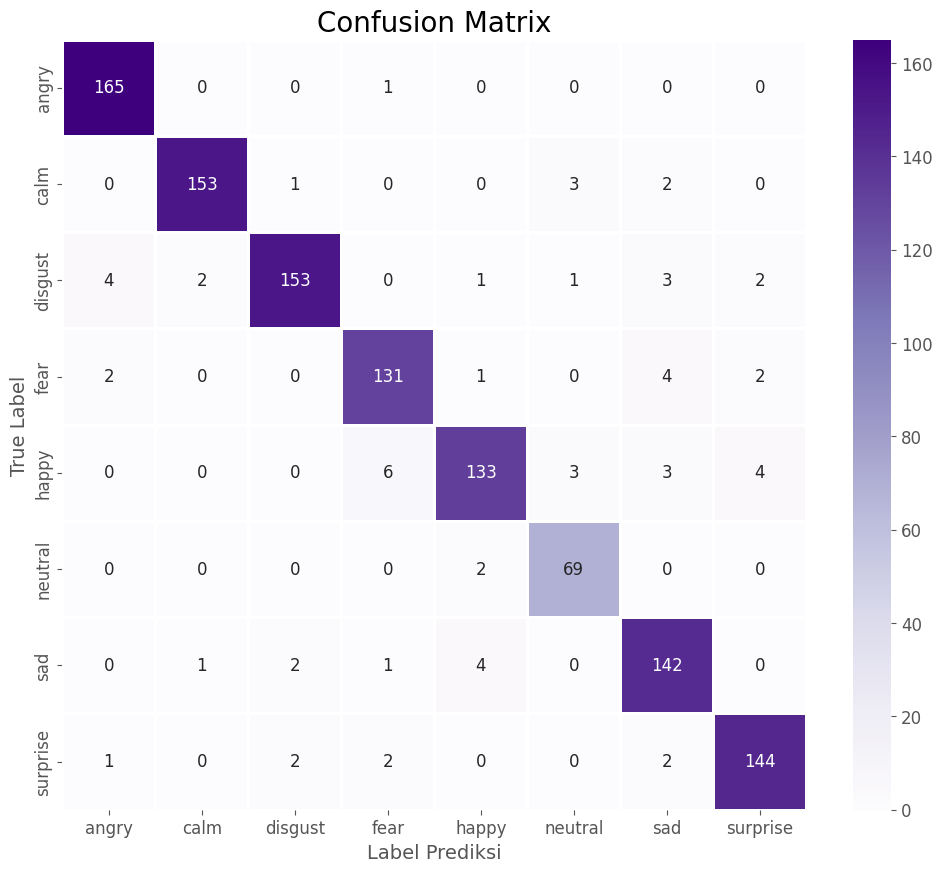

In [41]:
# Menghitung confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)

# Membuat DataFrame untuk confusion matrix
cm_df = pd.DataFrame(cm, index=encoder.classes_, columns=encoder.classes_)

# Memplot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm_df, annot=True, cmap='Purples', fmt='d', linecolor='white', linewidths=1)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Label Prediksi', size=14)
plt.ylabel('True Label', size=14)
plt.show()

### Menampilkan f1-score

In [42]:
# Menampilkan/mencetak classification report
print(classification_report(y_test_labels, y_pred_labels))

              precision    recall  f1-score   support

       angry       0.96      0.99      0.98       166
        calm       0.98      0.96      0.97       159
     disgust       0.97      0.92      0.94       166
        fear       0.93      0.94      0.93       140
       happy       0.94      0.89      0.92       149
     neutral       0.91      0.97      0.94        71
         sad       0.91      0.95      0.93       150
    surprise       0.95      0.95      0.95       151

    accuracy                           0.95      1152
   macro avg       0.94      0.95      0.94      1152
weighted avg       0.95      0.95      0.95      1152



## Save best model

In [43]:
import joblib
from tensorflow.keras.models import save_model

# Menyimpan model terbaik dalam format .keras dan .h5
save_model(final_model, 'best_model.keras')
final_model.save('best_model.h5')

# Analisis Emosi dari salah satu file audio

In [45]:
import numpy as np
import librosa
from joblib import load
from tensorflow.keras.models import load_model

# Memuat scaler, encoder, dan model
scaler = load('/kaggle/working/scaler.pkl')
encoder = load('/kaggle/working/label_encoder.pkl')
model = load_model('/kaggle/working/best_model.h5')

# Fungsi untuk mengklasifikasikan emosi dari file audio
def emotion_classifier(file_path, language='English'):
    class FeatureExtractor:
        def __init__(self, frame_length=2048, hop_length=512):
            # Inisialisasi parameter panjang frame dan hop
            self.frame_length = frame_length
            self.hop_length = hop_length

        def zcr(self, data):
            # Menghitung Zero Crossing Rate (ZCR) dari data audio
            return librosa.feature.zero_crossing_rate(data, frame_length=self.frame_length, hop_length=self.hop_length).flatten()

        def rmse(self, data):
            # Menghitung Root Mean Square Energy (RMSE) dari data audio
            return librosa.feature.rms(y=data, frame_length=self.frame_length, hop_length=self.hop_length).flatten()

        def mfcc(self, data, sr, n_mfcc=13, flatten=True):
            # Menghitung Mel-frequency Cepstral Coefficients (MFCC) dari data audio
            mfcc_features = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=n_mfcc, hop_length=self.hop_length)
            return mfcc_features.T.flatten() if flatten else mfcc_features.T

        def chroma(self, data, sr):
            # Menghitung Chroma dari data audio
            chroma_features = librosa.feature.chroma_stft(y=data, sr=sr, hop_length=self.hop_length)
            return chroma_features.T.flatten()

        def spectral_contrast(self, data, sr):
            # Menghitung Spectral Contrast dari data audio
            contrast_features = librosa.feature.spectral_contrast(y=data, sr=sr, hop_length=self.hop_length)
            return contrast_features.T.flatten()

        def mel_spectrogram(self, data, sr):
            # Menghitung Mel Spectrogram dari data audio dan mengubahnya ke dB
            mel_features = librosa.feature.melspectrogram(y=data, sr=sr, hop_length=self.hop_length)
            return librosa.power_to_db(mel_features).flatten()

        def extract_features(self, data, sr):
            # Mengekstraksi semua fitur dari data audio
            zcr_features = self.zcr(data)
            rmse_features = self.rmse(data)
            mfcc_features = self.mfcc(data, sr)
            chroma_features = self.chroma(data, sr)
            spectral_contrast_features = self.spectral_contrast(data, sr)
            mel_spectrogram_features = self.mel_spectrogram(data, sr)
            return np.concatenate([zcr_features,
                                    rmse_features,
                                    mfcc_features,
                                    chroma_features,
                                    spectral_contrast_features,
                                    mel_spectrogram_features])

    class DataAugmentation:
        @staticmethod
        def noise(data, noise_factor=0.005):
            # Menambahkan noise acak ke data audio
            noise_amp = noise_factor * np.random.uniform() * np.amax(data)
            return data + noise_amp * np.random.normal(size=data.shape[0])

        @staticmethod
        def pitch(data, sr, n_steps=4):
            # Mengubah pitch data audio
            return librosa.effects.pitch_shift(y=data, sr=sr, n_steps=n_steps)

    class AudioProcessor:
        def __init__(self, frame_length=2048, hop_length=512):
            # Inisialisasi ekstraktor fitur dan pengolah augmentasi data
            self.feature_extractor = FeatureExtractor(frame_length, hop_length)
            self.augmenter = DataAugmentation()

        def get_features(self, path, duration=2.5, offset=0.6):
            # Memuat file audio dan mengekstraksi fitur
            data, sr = librosa.load(path, duration=duration, offset=offset)
            features = [self.feature_extractor.extract_features(data, sr)]

            # Menambahkan noise ke audio dan mengekstraksi fitur
            noised_audio = self.augmenter.noise(data)
            features.append(self.feature_extractor.extract_features(noised_audio, sr))

            # Mengubah pitch audio dan mengekstraksi fitur
            pitched_audio = self.augmenter.pitch(data, sr)
            features.append(self.feature_extractor.extract_features(pitched_audio, sr))

            # Menambahkan noise dan mengubah pitch, kemudian mengekstraksi fitur
            pitched_noised_audio = self.augmenter.noise(pitched_audio)
            features.append(self.feature_extractor.extract_features(pitched_noised_audio, sr))

            return np.array(features)

        def process_feature(self, path, emotion):
            # Memproses fitur dan membuat label untuk satu file audio
            features = self.get_features(path)
            X = features.tolist()
            Y = [emotion] * len(features)
            return X, Y

    # Inisialisasi processor audio
    processor = AudioProcessor()

    # Memproses file audio untuk mengekstraksi fitur
    X = processor.get_features(file_path)

    # Menstandarisasi fitur
    X_scaled = scaler.transform(X)

    # Mengubah bentuk fitur untuk model
    X_scaled = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1, 1))

    # Memprediksi emosi
    predictions = model.predict(X_scaled)
    predicted_emotion = encoder.inverse_transform(np.argmax(predictions, axis=1))

    return predicted_emotion[0], predictions[0]


### Menampilkan hasil prediksi

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 921ms/step


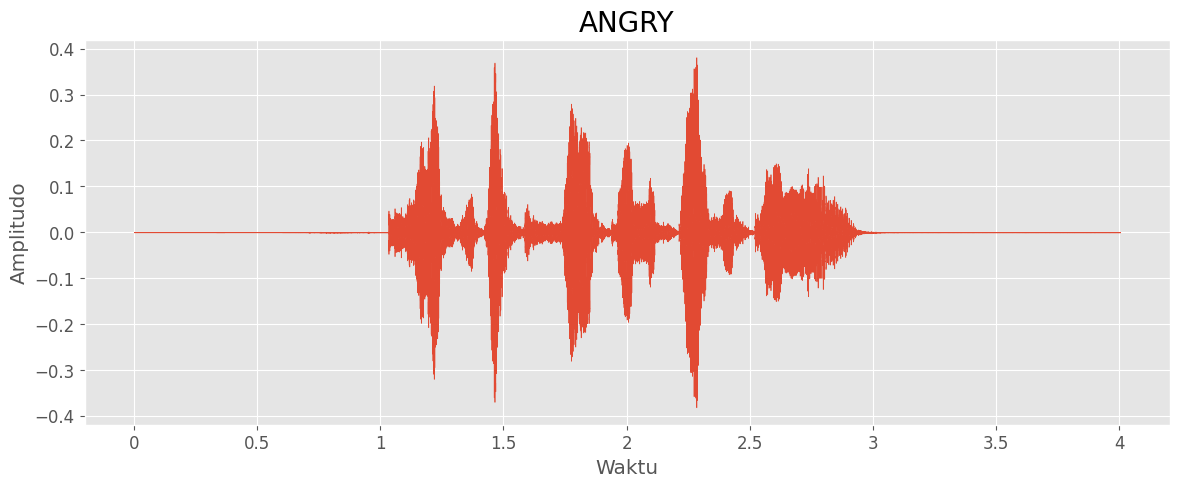

PREDICTED EMOTION: ANGRY


In [46]:
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt

# Fungsi untuk menampilkan audio, memplot waveform, dan memprediksi emosi
def analyze_audio(file_number):
    # Memilih file
    file_path = RAV_df['path'].iloc[file_number]
    audio_data, sr = librosa.load(file_path)
    
    # Menampilkan audio player
    ipd.display(ipd.Audio(data=audio_data, rate=sr))
    
    # Memprediksi emosi
    predicted_emotion, original_emotion = emotion_classifier(file_path, 'English')
    
    # Memplot waveform dengan judul emosi yang diprediksi
    plt.figure(figsize=(14, 5))
    librosa.display.waveshow(audio_data, sr=sr)
    plt.title(f'{predicted_emotion.upper()}', fontsize=20)
    plt.xlabel('Waktu')
    plt.ylabel('Amplitudo')
    plt.show()
    
    # Menampilkan prediksi dengan penekanan lebih berwarna hijau
    print(f'\033[1;32m\033[1mPREDICTED EMOTION: {predicted_emotion.upper()}\033[0m')
    
# Meminta input nomor file dari pengguna
analyze_audio(34)